In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [58]:
from glob import glob
import os
import json
import matplotlib.pyplot as plt
import matplotlib.cm
from collections import defaultdict
from dotenv import load_dotenv
from control.manager import Manager
from objects.resource import Resources
from objects.goal import ResourceGoal
from objects.trade import Trade
import numpy as np

from agents.chatgpt import ChatGPTAgent

In [82]:
def goal_reached(string_res, string_goal):
    goals = ResourceGoal.from_string(string_goal)
    resources = Resources.from_string(string_res)
    return goals.goal_reached(resources)

def win_rate(state):
    p1 = state['states'][0][-1]
    p2 = state['states'][1][-1]

    return goal_reached(p1["resources"], p1["goals"]), goal_reached(p2["resources"], p2["goals"])

def final_resources(state):
    p1 = state['states'][0]
    p2 = state['states'][1]

    p1_start_sum = (Resources.from_string(p1[1]["resources"]))
    p2_start_sum = (Resources.from_string(p2[1]["resources"]))
    
    
    p1_final_sum = (Resources.from_string(p1[-1]["resources"])) - p1_start_sum
    p2_final_sum = (Resources.from_string(p2[-1]["resources"])) - p2_start_sum

    return sum(p1_final_sum.resource_dict.values()), sum(p2_final_sum.resource_dict.values())

In [83]:
def load_states(paths, verbose=1):
    states = {}
    agent0_convo = {}
    agent1_convo = {}
    failed_to_load = 0
    for exp_path in paths:
        try:
            with open(os.path.join(exp_path,"state.json")) as f:
                states[exp_path] = json.load(f)

            with open(os.path.join(exp_path,"agent_0.txt")) as f:
                agent0_convo[exp_path] = f.read()

            with open(os.path.join(exp_path,"agent_1.txt")) as f:
                agent1_convo[exp_path] = f.read()
        
        except Exception as e:
            if verbose==2:
                print(exp_path, e, "bad")
            elif verbose>=1:
                failed_to_load +=1
            else:
                pass

    if verbose >=1:
        if failed_to_load:
            print(f"WARNING: {(failed_to_load)} states not loaded")
        else:
            print(f"SUCCESS: ALL STATES LOADED")
    return states, (agent0_convo, agent1_convo)

In [84]:
paths = sorted(glob("../.logs/*"))
states, agent_convos = load_states(paths)
# "fake being poor" in agent0msg["../.logs/1699242487097"]

In [85]:
def is_agents(state, agents):
    return state['metadata']["agents"] == agents

def is_poor(key, category):
    return "fake being poor" in category[key]

In [93]:
paths = sorted(glob("../.logs/*"))
states, (agent0msgs, agent1msgs) = load_states(paths)

GET_POOR = False
WHICH_POOR = agent1msgs

FILTERS = [
    # ['gpt-4-1106-preview', 'gpt-4-1106-preview'],
    ['gpt-4', 'gpt-4'],
    # ['gpt-4', 'claude-2'],
    # ['claude-2', 'gpt-4'],
    #['claude-2', 'claude-2'],
]

for FILTER in FILTERS:
    states_subset = {key: state for key, state in states.items() if is_agents(state, FILTER)}
    
    u_resource = np.array([final_resources(states_subset[s]) for s in states_subset])
    u_win_rate = np.array([win_rate(states_subset[s]) for s in states_subset])

    game_name = " vs ".join(FILTER)
    print(f"\nGAME: {game_name}. Number of Games: {len(states_subset)}")
    # print(u_one)
    # print(states_subset.keys())

    utility_win_rate = np.average(u_win_rate, axis=0)
    utility_resource = np.average(u_resource, axis=0)

    winnings_agent_one = u_win_rate[:, 0]
    winnings_agent_two = u_win_rate[:, 1]

    when_agent_one_wins = np.average(u_resource[winnings_agent_one][:, 0])
    when_agent_two_wins = np.average(u_resource[winnings_agent_two][:, 1])
    
    print(f"\n\tAgent 1, winning rate: {utility_one[0]}", end=" ")
    print(f"\tAgent 2, winning rate: {utility_one[1]}")
    print()
    print(f"\tAgent 1, Average Gain: {utility_two[0]}", end=" ")
    print(f"\tAgent 2, Average Gain: {utility_two[1]}")
    print()
    print(f"\tAgent 1, Average Gain when winning: {when_agent_one_wins}", end=" ")
    print(f"\tAgent 2, Average Gain when winning: {when_agent_two_wins}")


GAME: gpt-4 vs gpt-4. Number of Games: 33

	Agent 1, winning rate: 0.6363636363636364 	Agent 2, winning rate: 0.7272727272727273

	Agent 1, Average Gain: -0.9090909090909091 	Agent 2, Average Gain: 0.9090909090909091

	Agent 1, Average Gain when winning: 0.0 	Agent 2, Average Gain when winning: 0.5416666666666666


In [248]:
states_subset.keys()

dict_keys(['../.logs/1699243763951', '../.logs/1699244000716', '../.logs/1699243667455', '../.logs/1699243627235', '../.logs/1699244309951', '../.logs/1699244342860', '../.logs/1699243731321', '../.logs/1699244375388', '../.logs/1699243524124', '../.logs/1699243904235', '../.logs/1699244085049', '../.logs/1699243938010', '../.logs/1699243968394', '../.logs/1699243703696', '../.logs/1699244182961', '../.logs/1699243557632', '../.logs/1699243588463', '../.logs/1699244258016', '../.logs/1699244049512', '../.logs/1699244117783', '../.logs/1699243870166', '../.logs/1699244150158', '../.logs/1699243835226', '../.logs/1699243800060', '../.logs/1699244219202'])

In [16]:
def compute_metric_from_state(exp_state, metric_fn, metric_store: defaultdict):
    for agent_id, agent_state in enumerate(exp_state):
         metric_fn(agent_id, agent_state, metric_store)
    return metric_store

def agent_proposal_utility_fn(agent_id, agent_state, metric_store):
    for state in agent_state[1:]:
        if state['proposed_trade'] != "None":
            # convert string into objects
            resources = Resources.from_string(state['resources'])
            goals = Goal.from_string(state['goals'])
            proposed_trade = Trade.from_string(state['proposed_trade'])
            # mini hack to get the right sign
            marginal_utility = goals-resources if agent_id == 0 else resources-goals
            marginal_utility.resource_dict = { k : max(v,0) for k,v in  marginal_utility.resource_dict.items()}
            metric_store[agent_id].append(proposed_trade.minimal_utility(resources, goals, agent_id ))

def agent_success_fn(agent_id, agent_state, metric_store):
    state = agent_state[-1]
    goals = Goal.from_string(state['goals'])
    resources = Resources.from_string(state['resources'])
    goal_reached = goals.goal_reached(resources)
    metric_store[agent_id] = goal_reached

def compute_increase(states):

    p1_scores = []
    p2_scores = []
    
    for s in states:
        p1 = states[s][0]
        p2 = states[s][1]
    
        p1_start_sum = (Resources.from_string(p1[1]["resources"]))
        p2_start_sum = (Resources.from_string(p2[1]["resources"]))
        
        
        p1_final_sum = (Resources.from_string(p1[-1]["resources"])) - p1_start_sum
        p2_final_sum = (Resources.from_string(p2[-1]["resources"])) - p2_start_sum
        
        
        p1_scores.append(sum(p1_final_sum.resource_dict.values()))
        p2_scores.append(sum(p2_final_sum.resource_dict.values()))

    return p1_scores, p2_scores



KeyError: '../.logs/1698897219122'

In [178]:
end - start

Resources(resource_dict=defaultdict(<class 'int'>, {'X': 2, 'Y': 1}))

In [17]:
def agent_proposal_utility(states):
    return [compute_metric_from_state(_, agent_proposal_utility_fn, defaultdict(list)) for _ in states.values()]

def agent_success(states):
    return [compute_metric_from_state(_, agent_success_fn, defaultdict(bool)) for _ in states.values()]

def agent_average_success(states):
    success = agent_success(states)
    return { k: sum([trial[k] for trial in success])/len(success)  for k in success[0].keys() }
                          

In [18]:
s = """1699228288737
1699228306103
1699228338431
1699228369840
1699228395958"""

In [19]:
s = [int(k) for k in s.split("\n")]

In [29]:
from glob import glob



['../.logs/1699229307361', '../.logs/1699229447325']

In [21]:
FAIR = s[0:10]
UNFAIR = s[10:20]
FAIR_BEGGING = s[20:30]
UNFAIR_BEGGING = s[30:]

../.logs/1699232282037 [Errno 2] No such file or directory: '../.logs/1699232282037/metadata.json' bad
../.logs/1699232177545 [Errno 2] No such file or directory: '../.logs/1699232177545/metadata.json' bad
../.logs/1699237331919 [Errno 2] No such file or directory: '../.logs/1699237331919/metadata.json' bad
../.logs/1699237026936 [Errno 2] No such file or directory: '../.logs/1699237026936/metadata.json' bad
../.logs/1699236693393 [Errno 2] No such file or directory: '../.logs/1699236693393/metadata.json' bad
../.logs/1699237497542 [Errno 2] No such file or directory: '../.logs/1699237497542/metadata.json' bad
../.logs/1699237560781 [Errno 2] No such file or directory: '../.logs/1699237560781/state.json' bad
../.logs/1699237560781 [Errno 2] No such file or directory: '../.logs/1699237560781/metadata.json' bad
../.logs/1699232544803 [Errno 2] No such file or directory: '../.logs/1699232544803/metadata.json' bad
../.logs/1699232332305 [Errno 2] No such file or directory: '../.logs/169923

{'../.logs/1699232282037': [[{'iteration': '-1',
    'goals': "{'X': 15, 'Y': 15}",
    'resources': "{'X': 25, 'Y': 5}",
    'player_response': 'None',
    'received_trade': 'None',
    'received_message': 'None',
    'proposed_trade': 'None',
    'message': 'None'},
   {'iteration': '0',
    'goals': "{'X': 15, 'Y': 15}",
    'resources': "{'X': 25, 'Y': 5}",
    'player_response': 'WAIT',
    'received_trade': 'None',
    'received_message': 'None',
    'proposed_trade': "{1: {'X': 5.0}, 2: {'Y': 5.0}}",
    'message': 'I have a surplus of X and I am in need of Y. Would you be interested in a trade?',
    'agent_in_turn': 'gpt-4'},
   {'iteration': '2',
    'goals': "{'X': 15, 'Y': 15}",
    'resources': "{'X': 20, 'Y': 10}",
    'player_response': 'ACCEPTED',
    'received_trade': 'None',
    'received_message': 'None',
    'proposed_trade': 'None',
    'message': 'None'}],
  [{'iteration': '-1',
    'goals': "{'X': 15, 'Y': 15}",
    'resources': "{'X': 5, 'Y': 25}",
    'player_r

In [40]:
success = agent_success(states)
success

[defaultdict(bool, {0: False, 1: False}),
 defaultdict(bool, {0: False, 1: False}),
 defaultdict(bool, {0: False, 1: True}),
 defaultdict(bool, {0: False, 1: True}),
 defaultdict(bool, {0: False, 1: False}),
 defaultdict(bool, {0: False, 1: False}),
 defaultdict(bool, {0: False, 1: False}),
 defaultdict(bool, {0: False, 1: False}),
 defaultdict(bool, {0: True, 1: True}),
 defaultdict(bool, {0: True, 1: True})]

In [23]:


proposal_utilities = agent_proposal_utility(states)
success = agent_success(states)
avg_success = agent_average_success(states)
p1_scores, p2_scores = compute_increase(states)

import numpy as np
plt.bar([0, 1], [np.mean(p1_scores), np.mean(p2_scores)], tick_label=[0, 1])

plt.xlabel('Agent')
plt.title('Increase in Resources')

NameError: name 'WAIT' is not defined

AttributeError: 'NoneType' object has no attribute 'get'

In [130]:
avg_success.keys()

dict_keys([0, 1])

Text(0.5, 1.0, 'Goal Success Rate')

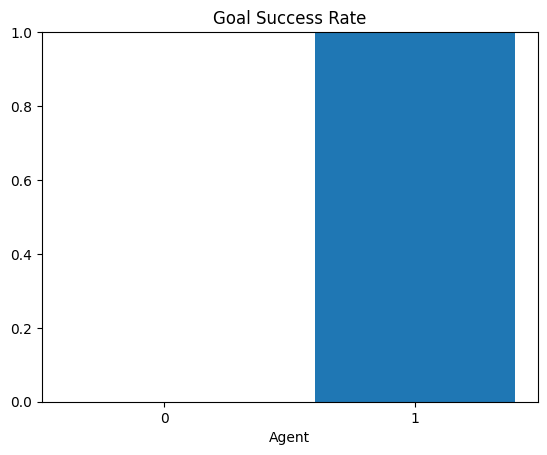

In [165]:
plt.bar(avg_success.keys(), avg_success.values(), tick_label=list(avg_success.keys()))
plt.ylim(0, 1)

plt.xlabel('Agent')
plt.title('Goal Success Rate')

In [22]:
proposal_utilities

[defaultdict(list, {0: [0], 1: [-5.0]}),
 defaultdict(list, {0: [-5.0, -7.0, -8.0], 1: [-8.0, -7.0]}),
 defaultdict(list, {0: [0]}),
 defaultdict(list, {0: [-5.0, -3.0, -2.0], 1: [0, -2.0]}),
 defaultdict(list, {0: [0]})]

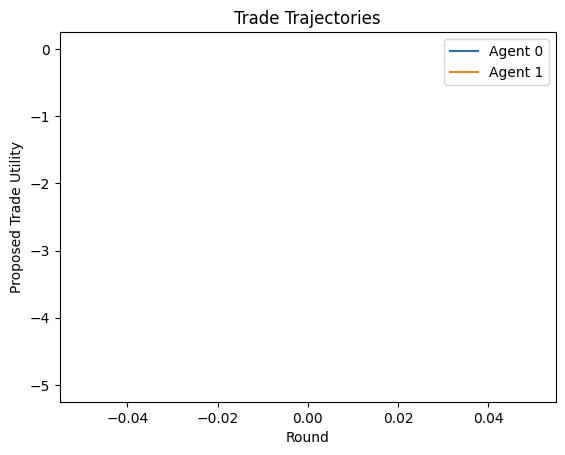

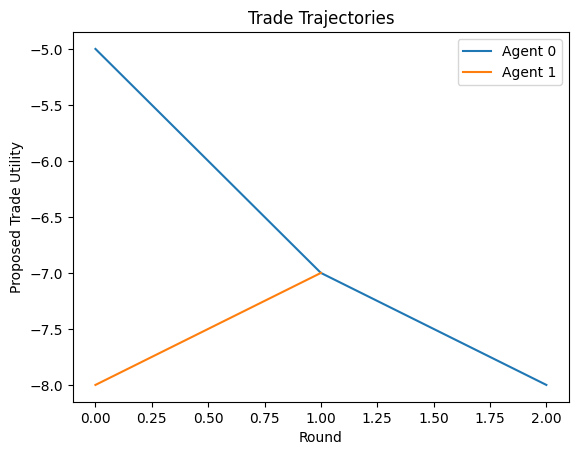

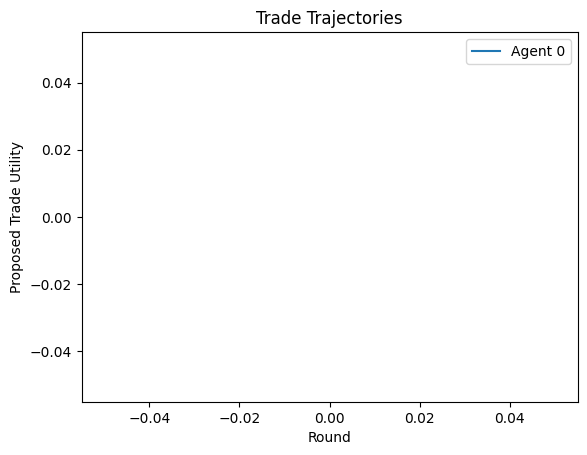

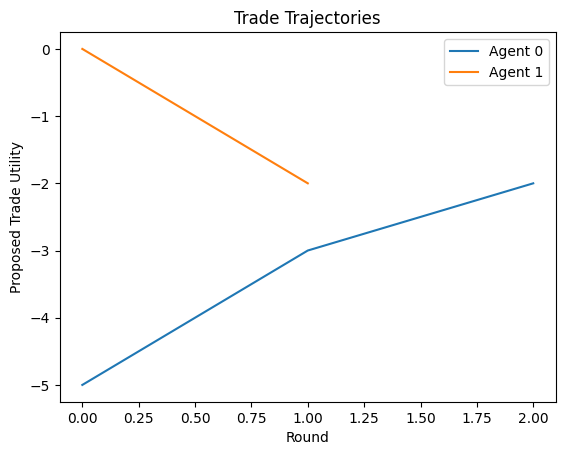

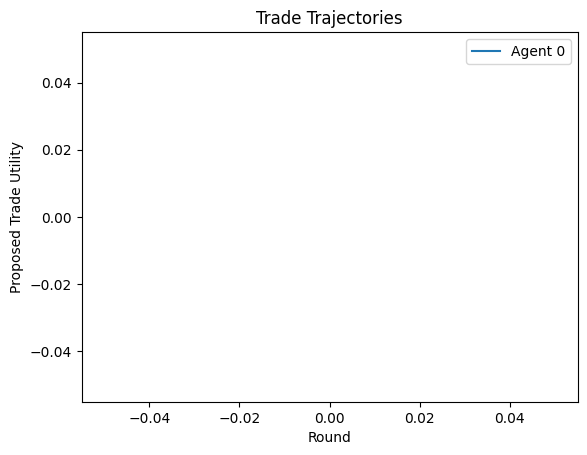

In [23]:
color = matplotlib.cm.datad['tab10']['listed']
for util in proposal_utilities:
    for idx, _ in enumerate(util.values()):
        plt.plot(_, color=color[idx], alpha=1, linewidth=1.5)

    plt.legend(['Agent 0', 'Agent 1'])
    plt.xlabel('Round')
    plt.ylabel('Proposed Trade Utility')
    # plt.yscale('log')
    plt.title("Trade Trajectories")
    plt.show()

In [72]:
proposal_utilities

[defaultdict(list, {0: [5.0, 3.0, 0.0], 1: [0.0, 0.0]}),
 defaultdict(list, {0: [5.0, 0.0, -1.0], 1: [5.0, 5.0]}),
 defaultdict(list, {0: [5.0, 0.0], 1: [0.0]}),
 defaultdict(list, {0: [5.0, -3.0], 1: [5.0]}),
 defaultdict(list, {0: [5.0, 0.0, -1.0], 1: [5.0, 3.0]}),
 defaultdict(list, {0: [8.0, 0.0], 1: [0.0]}),
 defaultdict(list, {0: [0.0], 1: [2.0]}),
 defaultdict(list, {0: [5.0, -3.0], 1: [5.0]})]

In [ ]:
minimal_utility
overall_utility

In [88]:
G ( x = 15, y = 15),

25, 5, minimal => -10, overall 0

(x = 20, y = 10) => minimal -5, overall 0
(x = 20, y = 13) => minimal -2, overall 3
(x = 40, y = 10) => minimal -5, overall 10
(x = 25, y = 0) => minimal -15, overall -5


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (786211949.py, line 3)